<h1> 501 Data Pipeline Workshop 9/24 </h1>
<h3> Part 2: Network Model</h3>

<p>Now that we're more familiar with the data and have some ideas, let's build an agent based model to simulate the flow of information across the "thought collective"</p>
<p>In the model, each creator is a node, and when two or more creators are listed for a single document, that usually means they are corresponding via letter, or collaborating on a project. Letters and collaborations are communicative pathways over which new ideas can be transmitted.</p>
<p>How far and at what speed might a new idea traverse this network, if it originated with one of our hub scientists?</p>

In [ ]:
## Imports
# Some the same as part 1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Networkx for building a network to visualize
import networkx as nx
# Itertools for making combinations
import itertools
# Random for instantiating random variables when we run the simulation
import random

# These are for running the simulation in a readable way
from IPython.display import clear_output
import time

## And we need to import the cybernetics data again from the csv file
cybernetics_data = pd.read_csv ('CTC_Machine-Generated-Data.csv')

<h3>To build a network in networkx, we are going to make a list of nodes and a dataframe with information about edges.</h3>
<p>The nodes will be pairs of document creators, a proxy for people in communication with one another. The edges dataframe will record source, target, and weight for each edge. Weight here is the frequency of occurence, or how many times these two people are listed together in a document.</p>

In [76]:
## Set up a network

# List all the creators
creator_list = []
for i in cybernetics_data['Creator']:
    if not pd.isna(i):
        creator_list.append(i.split('||'))

# Remove duplicates
creator_set = [item for sublist in creator_list for item in sublist]
creator_set = set(creator_set)

# Create an empty edges dataframe with 'Source', 'Target', and 'Weight' columns
column_names = ['Source', 'Target', 'Weight']
edges_df = pd.DataFrame(columns=column_names)

# Turn every creator list into pairs
new_creator_list=[]
for entry in creator_list:
    if len(entry)==2:
        new_creator_list.append(entry)
    elif len(entry)>2:
        for combination in itertools.combinations(entry, 2):
            new_creator_list.append(list(combination))

data_series = pd.Series(new_creator_list)

# Calculate the frequency of each unique value
frequency_table = data_series.value_counts().reset_index()

# Fill in the edges dataframe from the frequency table
for row in range(len(frequency_table)):
    edges_df.at[row, 'Source'] = frequency_table['index'][row][0]
    edges_df.at[row, 'Target'] = frequency_table['index'][row][1]
    edges_df.at[row, 'Weight'] = frequency_table['count'][row]

display (edges_df)

,Source,Target,Weight
0,"Veblen, Oswald","Wiener, Norbert",12
1,"Jordan, E.C.","von Foerster, Heinz",10
2,"Wiener, Leo","Wiener, Norbert",9
3,"Bush, Vannevar","Wiener, Norbert",8
4,"Lee, Y.W.","Wiener, Norbert",8
...,...,...,...
1998,"Mead, Margaret","Fremont-Smith, Frank",1
1999,"Maturana, Humberto R.","Varela, Francisco",1
2000,"Bateson, Gregory","Pitts, Walter",1
2001,"Bateson, Gregory","Wiener, Norbert",1


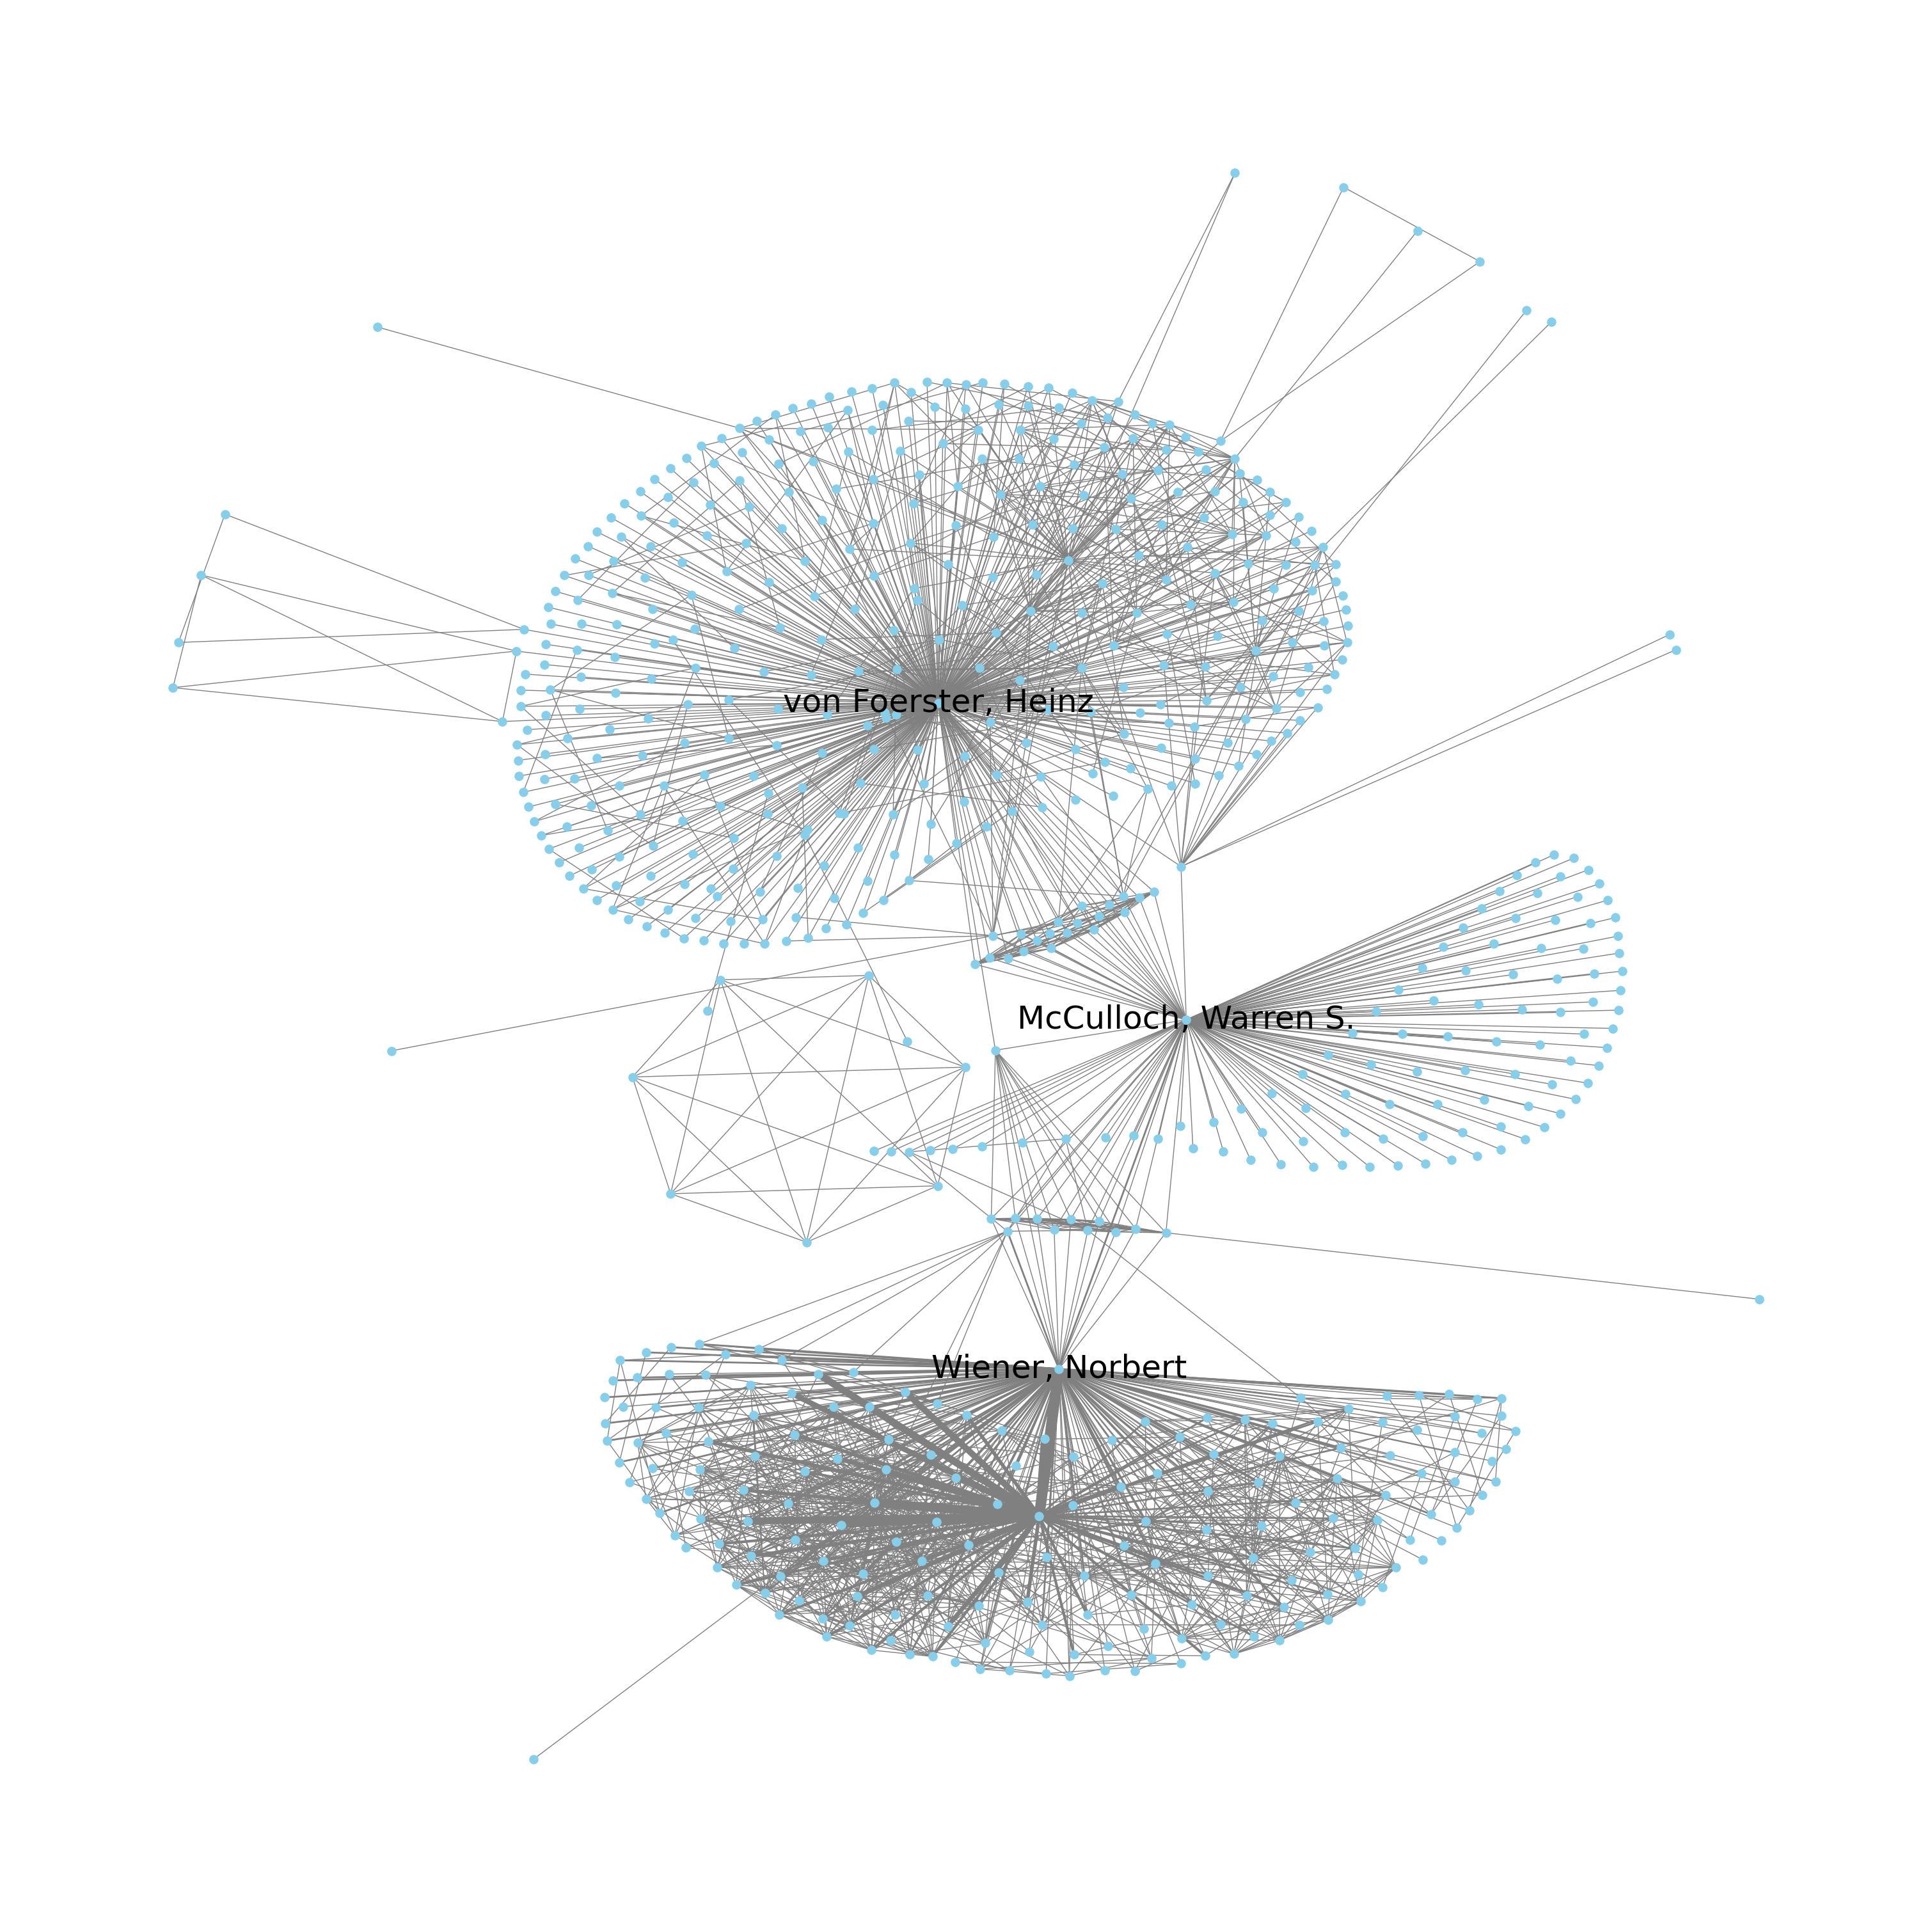

In [77]:
## Now we can make and print a representation of the network

# Make an undirected graph
G = nx.Graph()

# Add nodes
G.add_nodes_from(list(creator_set))

# Add edges
G = nx.from_pandas_edgelist(edges_df, source='Source', target='Target', edge_attr='Weight')

# Set up a layout (this moves around the node positions to a legible layout)
pos = nx.kamada_kawai_layout(G)

# Set figure size
plt.rcParams["figure.figsize"] = [30, 30]

# Define the nodes you want to label
hubs= ['Wiener, Norbert', 'McCulloch, Warren S.','von Foerster, Heinz']

labels = {}    
for node in G.nodes():
    if node in hubs:
        #set the node name as the key and the label as its value 
        labels[node] = node

# Draw the network
nx.draw(G, pos, width=edges_df['Weight'], with_labels=False, node_color='skyblue', edge_color='gray', node_size=90)

# Draw the labels for the hub nodes
nx.draw_networkx_labels(G, pos, labels=labels, font_size=36, font_color='black')

# repositioning the nodes takes a bit so give this code a minute to run
plt.show()

In [ ]:
## If you use gephi, you can use this cell to save the network so that you can open it in gephi and play around with some different layouts
nx.write_gexf(G, "cyber_network.gexf")

<h3>We want to see how information flows over this network over time.</h3>
<p>We can do that without actually using the networkx constructed network, but instead testing for individual links over time.
<br>We can also include some additional information for each edge, related to the machine extracted topics of discussion in each document.
</p>

In [78]:
## Make a new network dataframe to use in the simulation

# First we need to add a year column to clean up the 'Date' column and make it a single year for that document/communication
# This is a HUGE simplification of the archival data, but the most straightforward way to deal with 'years' for our toy model.
cybernetics_data['year'] = cybernetics_data['Date'].str.split('-|\|\|').str.get(0)
cybernetics_data['year'] = cybernetics_data['year'].str.replace(r'[^0-9]', '', regex=True)
cybernetics_data['year'] = pd.to_numeric(cybernetics_data['year'])

# Next, we break up the 'Classification Certainty (Machine Generated)' into its component percentages
cybernetics_data['personal'] = cybernetics_data['Classification Certainty (Machine Generated)'].str.extract('(?<=Personal,)\s*([\d.]+)(?=%)')
cybernetics_data['math'] = cybernetics_data['Classification Certainty (Machine Generated)'].str.extract('(?<=Math,)\s*([\d.]+)(?=%)')
cybernetics_data['psychology'] = cybernetics_data['Classification Certainty (Machine Generated)'].str.extract('(?<=Psychology,)\s*([\d.]+)(?=%)')
cybernetics_data['machines'] = cybernetics_data['Classification Certainty (Machine Generated)'].str.extract('(?<=Machines,)\s*([\d.]+)(?=%)')

# Remove all rows with nan
cybernetics_data = cybernetics_data.dropna(subset=['Creator']).reset_index(drop=True)

# Make a new edges dataframe with the following columns:
column_names = ['Source', 'Target', 'Year', 'Personal','Math','Psychology','Machines']
all_edges_df = pd.DataFrame(columns=column_names)

# for every document in the main df, make a row in the new dataframe for each pair of creators
for row in range(len(cybernetics_data)):
    creator_list = cybernetics_data.at[row, 'Creator'].split('||')
    if len(creator_list) == 2:
        source = creator_list[0]
        target = creator_list[1]
        year = cybernetics_data.at[row, 'year']
        personal = cybernetics_data.at[row, 'personal']
        math = cybernetics_data.at[row, 'math']
        psychology = cybernetics_data.at[row, 'psychology']
        machines = cybernetics_data.at[row, 'machines']
        all_edges_df.loc[len(all_edges_df)] = [source, target, year, personal, math, psychology, machines]
    elif len(creator_list)>2:
        for combination in itertools.combinations(creator_list, 2):
            source = combination[0]
            target = combination[1]
            year = cybernetics_data.at[row, 'year']
            personal = cybernetics_data.at[row, 'personal']
            math = cybernetics_data.at[row, 'math']
            psychology = cybernetics_data.at[row, 'psychology']
            machines = cybernetics_data.at[row, 'machines']
            all_edges_df.loc[len(all_edges_df)] = [source, target, year, personal, math, psychology, machines]

# Add a 'none' column to run the simulation without a topic category
all_edges_df['None'] = 100

display(all_edges_df)

,Source,Target,Year,Personal,Math,Psychology,Machines,None
0,"von Foerster, Heinz","Inselberg, Alfred",1962.0,99.96,0.04,0.00,0.00,100
1,"von Foerster, Heinz","Pask, Gordon",1960.0,100.00,0.00,0.00,0.00,100
2,"Russell, John K.","Ashby, W. Ross (William Ross)",1963.0,99.99,0.01,0.00,0.00,100
3,"Uribe, Ricardo B.","Maturana, Humberto R.",1974.0,82.48,0.00,17.52,0.00,100
4,"Uribe, Ricardo B.","Varela, Francisco",1974.0,82.48,0.00,17.52,0.00,100
...,...,...,...,...,...,...,...,...
2217,"Einstein, Albert","Turing, Alan",1946.0,99.99,0.01,0.00,0.00,100
2218,"Einstein, Albert","McCulloch, Warren S.",1946.0,99.99,0.01,0.00,0.00,100
2219,"Carnap, Rudolf","Turing, Alan",1946.0,99.99,0.01,0.00,0.00,100
2220,"Carnap, Rudolf","McCulloch, Warren S.",1946.0,99.99,0.01,0.00,0.00,100


<h3>Now we can run our model.</h3>
<p>In this simulation, each step represents a year. Every year, a certain number of letters is sent out, which in our model exactly matches the data of actual node connections from that year. In this model, there is some chance that each of those letters might contain the 'new idea' or 'news' that originates with one of our main four 'hub' scientists.</p>

In [79]:
### set your parameters

# The news_index represents the chance that, if one person in a linked pair knows the news, 
# they will tell the other person in that pair
# This should be a number between 0 and 1. The higher the number, the more likely the news will be passed on
news_index = .8

# seed_nodes is a list with the four hub scientists who are the possible originators of the news or idea
# This list could be augmented with any other node names (e.g. "Einstein, Albert" or "Mead, Margaret")
seed_nodes = ['Ashby, W. Ross', 'Wiener, Norbert', 'McCulloch, Warren S.','von Foerster, Heinz']
# set as one name if you want to pick a particular seed
# set as "random.choice(seed_nodes)" if you want it to be a random choice from the list
seed = random.choice(seed_nodes)

news_topic = ['Personal','Math','Psychology','Machines']
# If no topic, set topic = 'None' and all messages/links will have an equal chance of containing the news
# set as "random.choice(news_topic)" if you want it to be a random choice from the list
topic = 'Personal'

# the start year represents the "origin year" of the news or idea, and the model will begin at that year
start_year = 1920
end_year = 1975

In [81]:
## Now we draw a network for every year and calculate a chance that that news gets mentioned
## At each step we update: the year, letters written, new people informed, % of network that knows the news

# set the list of people who know from the beginning (just the seed person)
in_the_know = [seed]
print (in_the_know)

# Make a list of all the nodes in the network so we know what percentage already knows
all_nodes = all_edges_df['Source'].tolist() + all_edges_df['Target'].tolist()
all_nodes = list(set(all_nodes))

# For each year, calculate and print the model output
for year in range (start_year, end_year):
    clear_output(wait=True)
    print (seed)
    print (year)
    # If any of those letters includes someone in_the_know
    letters_links = all_edges_df.loc[all_edges_df['Year'] == year].reset_index(drop=True)
    # Make empty list for the people informed in this year
    new_folk = []
    for row in range(len(letters_links)):
        ##check if in the know
        source = letters_links.at[row,'Source']
        target = letters_links.at[row,'Target']
        news_index_num = news_index*(pd.to_numeric(letters_links.at[row,topic])/100)
        if source in in_the_know:
            delivery_chance = random.uniform(0, 1)
            if delivery_chance < news_index_num:
            #add the new person to in the know and print them
                if target not in in_the_know:
                    in_the_know.append (target)
                    new_folk.append(target)
        elif target in in_the_know:
            delivery_chance = random.uniform(0, 1)
            if delivery_chance < news_index_num:
                if source not in in_the_know:
                    #add the new person to in the know and print them    
                    in_the_know.append (source)
                    new_folk.append(source)

    # Print the number of people in the know
    print ("People in the know: ",len(in_the_know))
    #print percentage of network in the know
    print ("Percent of network in the know: ", len(in_the_know)/len(all_nodes)*100,'%')
    print ("People who just learned: ")
    for i in new_folk:
        print (i)
    print ("letters sent this year:")
    print (cybernetics_data.loc[cybernetics_data['year'] == year,['Creator']])

    #pause for a second so you can read the output
    time.sleep(.5)
    

Wiener, Norbert
1974
People in the know:  382
Percent of network in the know:  54.57142857142857 %
People who just learned: 
Geyer, Felix
Glanville, Ranulph
Letelier, Gloria
Ackoff, Russell L.
Dolge, Jonathan
Lilly, Toni
Boerstein, Walter S.
Easley, Jack
Greene, Peter
Grothe, David
Kelley, K.
White, John
McCune, Robert C.
Neal, Tom W.
Fonseca, Jose
Buckley, Walter
letters sent this year:
                                               Creator
13   Uribe, Ricardo B.||Maturana, Humberto R.||Vare...
22                Gaburo, Kenneth||von Foerster, Heinz
24                   Geyer, Felix||von Foerster, Heinz
26             von Foerster, Heinz||Glanville, Ranulph
31   von Foerster, Heinz||Letelier, Gloria||Beer, S...
40                Fischer, Roland||von Foerster, Heinz
64                 von Foerster, Heinz||Mead, Margaret
79              von Foerster, Heinz||Michael, Patricia
86               Mendius, Barbara||von Foerster, Heinz
99              von Foerster, Heinz||Leretaille, Louis
101 

<h3>Now we can run a number of trials of this simulation to look at the patterns. </h3>

In [82]:
### Set your parameters
trials = 20

news_index = .8
##choose a seed that's one of our four main guys
seed_nodes = ['Ashby, W. Ross', 'Wiener, Norbert', 'McCulloch, Warren S.','von Foerster, Heinz']
colors = ['r', 'g', 'b', 'c']

news_topic = ['Personal','Math','Psychology','Machines', 'None']
#if no topic, set topic = 'None' and all messages/links will have an equal chance of containing the news

start_year = 1920
end_year = 1975

## N.B. you need to change the "seed_choice" and "topic_choice" variables in the for loop 
# in the next cell in order to change those parameters

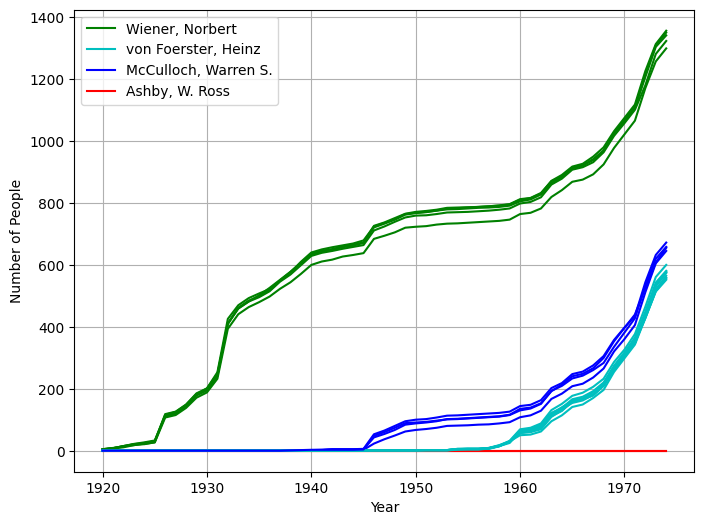

In [84]:
## Run the simulation X times and make a line chart
all_nodes = all_edges_df['Source'].tolist() + all_edges_df['Target'].tolist()
all_nodes = list(set(all_nodes))

# Create a figures
plt.figure(figsize=(8, 6))

# Plot each trial
for trial in range (trials):
    ### Change this to change the initial seed node or make a random choice
    seed_choice = random.randint(0, 3)
    seed = seed_nodes[seed_choice]
    ### Change this to change the topic or make a random choice
    # 0-Personal 1-Math 2-Psychology 3-Machines 4-None
    topic_choice = 4
    topic = news_topic[topic_choice]
    in_the_know = [seed]

    column_names = ['year', 'no_people', 'percentage']
    trial_df = pd.DataFrame(columns=column_names)
    trial_df['year'] = range (start_year, end_year)
    no_people_peryr = []
    percentage_peryr = []
    for year in range (start_year, end_year):

        letters_links = all_edges_df.loc[all_edges_df['Year'] == year].reset_index(drop=True)
        for row in range(len(letters_links)):
            source = letters_links.at[row,'Source']
            target = letters_links.at[row,'Target']
            news_index_num = news_index*(pd.to_numeric(letters_links.at[row,topic])/100)
            if (source in in_the_know):
                delivery_chance = random.uniform(0, 1)
                if delivery_chance < news_index_num:
                    in_the_know.append (target)
            elif (target in in_the_know):
                delivery_chance = random.uniform(0, 1)
                if delivery_chance < news_index_num:
                    in_the_know.append (source)
    
        # Number of people in the know
        no_people_peryr.append(len(in_the_know))
        
        # Percentage of network in the know
        percentage_peryr.append(len(in_the_know)/len(all_nodes)*100)
    
    # Save no of people and percentage of network in the know in its own dataframe
    trial_df['no_people'] = no_people_peryr
    trial_df['percentage'] = percentage_peryr

    plt.plot(trial_df['year'], trial_df['no_people'], color=colors[seed_choice], label = seed)

plt.xlabel("Year")
plt.ylabel("Number of People")
plt.legend()

# Get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Create a dictionary to remove duplicates
by_label = dict(zip(labels, handles))

# Generate the legend with unique entries
plt.legend(by_label.values(), by_label.keys())

plt.grid(True)
plt.show()